0:	learn: 1.0974768	total: 513us	remaining: 12.3ms
1:	learn: 0.9808005	total: 1.02ms	remaining: 11.8ms
2:	learn: 0.9093758	total: 1.41ms	remaining: 10.3ms
3:	learn: 0.8732449	total: 1.76ms	remaining: 9.22ms
4:	learn: 0.8598204	total: 2.11ms	remaining: 8.44ms
5:	learn: 0.8495287	total: 2.44ms	remaining: 7.75ms
6:	learn: 0.8174956	total: 2.81ms	remaining: 7.24ms
7:	learn: 0.8011281	total: 3.21ms	remaining: 6.82ms
8:	learn: 0.7950565	total: 3.61ms	remaining: 6.42ms
9:	learn: 0.7711479	total: 4.02ms	remaining: 6.03ms
10:	learn: 0.7564938	total: 4.46ms	remaining: 5.68ms
11:	learn: 0.7317594	total: 4.81ms	remaining: 5.21ms
12:	learn: 0.7226351	total: 5.16ms	remaining: 4.76ms
13:	learn: 0.7106613	total: 5.54ms	remaining: 4.36ms
14:	learn: 0.7057292	total: 5.9ms	remaining: 3.93ms
15:	learn: 0.6967827	total: 6.25ms	remaining: 3.52ms
16:	learn: 0.6936670	total: 6.6ms	remaining: 3.11ms
17:	learn: 0.6787047	total: 7.01ms	remaining: 2.73ms
18:	learn: 0.6711548	total: 7.47ms	remaining: 2.36ms
19:	le

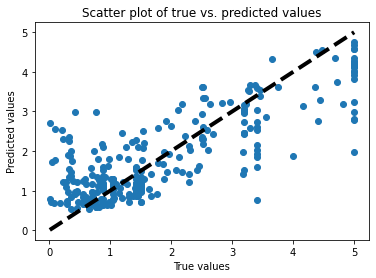

Training set:
R2: 0.772493830741046
NSE: 0.772493830741046
RMSE: 0.6626959492676506
MAE: 0.491335309185785

Testing set:
R2: 0.6549256248131263
NSE: 0.6549256248131263
RMSE: 0.8366519647059295
MAE: 0.6153365243017543


In [3]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Load and preprocess the dataset
data = pd.read_csv('VIS1S2PMETmSC.csv')

data = data.dropna() 
data['ET_wb'] = data['ET_wb'].astype(float)
#data_filtered = data[(data['ET_wb'] >= 0.1) & (data['SM'] <= 0.35)]

X = data.iloc[:, [8,15]].values

# Perform scaling on the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = data.iloc[:, 19].values 
y = y.reshape(-1, 1)
y = np.ravel(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=43)

# Define the CatBoost model
model = CatBoostRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [25],
    'depth': [5],
    'learning_rate': [0.6],
    'loss_function': ['RMSE'],
}

# Perform cross-validation using GridSearchCV
kfold = KFold(n_splits=5, shuffle=True, random_state=43)
cv_model = GridSearchCV(model, param_grid, cv=kfold, scoring='neg_mean_squared_error')
cv_model.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", cv_model.best_params_)

# Train the final model with the best hyperparameters
final_model = CatBoostRegressor(**cv_model.best_params_)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

T4SCSM1_CB = pd.DataFrame({'Measured': y_test.flatten(), 'Estimated': y_pred.flatten()})

# Save the DataFrame to a file
T4SCSM1_CB.to_csv('SCSM12_CB.csv', index=False)

plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of true vs. predicted values')

# add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# show the plot
plt.show()

y_train_pred = final_model.predict(X_train)
y_train = y_train.reshape(-1)
y_train_pred = y_train_pred.reshape(-1)
mean_y_train = y_train.mean()
y_train_mean = np.repeat(y_train.mean(), y_train.shape[0])

train_r2 = r2_score(y_train, y_train_pred)
train_nse = 1 - mean_squared_error(y_train, y_train_pred)/mean_squared_error(y_train, y_train_mean)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Training set:")
print("R2:", train_r2)
print("NSE:", train_nse)
print("RMSE:", train_rmse)
print("MAE:", train_mae)
print()

metricstrain = [
    {'Metric': 'RMSE', 'Value': train_rmse},
    {'Metric': 'R2', 'Value': train_r2},
    {'Metric': 'NSE', 'Value': train_nse},
    {'Metric': 'MAE', 'Value': train_mae}
]

df = pd.DataFrame(metricstrain)
df.to_csv('CBSC_trainmetrics.csv', index=False)

y_test_pred = final_model.predict(X_test)
y_test = y_test.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
mean_y_test = y_test.mean()
y_test_mean = np.repeat(y_test.mean(), y_test.shape[0])

test_r2 = r2_score(y_test, y_test_pred)
test_nse = 1 - mean_squared_error(y_test, y_test_pred)/mean_squared_error(y_test, y_test_mean)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Testing set:")
print("R2:", test_r2)
print("NSE:", test_nse)
print("RMSE:", test_rmse)
print("MAE:", test_mae)

metricstest = [
    {'Metric': 'RMSE', 'Value': test_rmse},
    {'Metric': 'R2', 'Value': test_r2},
    {'Metric': 'NSE', 'Value': test_nse},
    {'Metric': 'MAE', 'Value': test_mae}
]

df = pd.DataFrame(metricstest)
df.to_csv('CBSC_testmetrics.csv', index=False)
